## Gradient Boosting Classifier
This notebook defines the python script corresponding to the non-DL track. The selected multinomial classifier is the **XGB** implementation which supports the GPU acceleration

In [1]:
# load training set
import pandas as pd
import numpy as np

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('c:/Users/I051796/Projects/CES/data/label.csv', sep=';')

In [3]:
# vectorize the text with TF-IDF transform
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

vectorizer = TfidfVectorizer(strip_accents='ascii')
XTFIDFVectorizedTrain = vectorizer.fit_transform(XTrain['question'])
XTFIDFVectorizedTrain = pd.DataFrame(XTFIDFVectorizedTrain.toarray())
XTFIDFVectorizedTrain.head(2)

,0,1,2,3,4,5,6,7,8,9,...,8199,8200,8201,8202,8203,8204,8205,8206,8207,8208
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# perform a dimensional reduction into 600 dimensional space
# use the same dimensionality than the one provided by fasttext embedding model in the DL context
from sklearn.decomposition import PCA

PCATransform = PCA(n_components=600)
PCAXTrain = pd.DataFrame(PCATransform.fit_transform(XTFIDFVectorizedTrain))

In [48]:
# combine input features from above text vectorization with text characteristics features (../../data/staging_data/text_extracted_features.csv)
extractedFeatures = pd.read_csv('../../data/staging_data/text_extracted_features.csv', sep=',')
mergedXTrain = PCAXTrain.join(extractedFeatures, lsuffix='', rsuffix='')
mergedXTrain.head(5)

,0,1,2,3,4,5,6,7,8,9,...,quandCount,quoiCount,commentCount,avecCount,etCount,ouCount,interrogativeIndex,interrogativeWordIndex,drugWordIndex,drugInterrogativeDistance
0,-0.039286,0.082099,-0.020692,-0.017599,-0.005236,0.019263,-0.000620,-0.001469,0.031438,-0.019861,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,-0.007663,-0.080287,-0.056888,-0.026366,0.066028,0.034572,0.010868,0.007431,-0.011724,0.007254,...,0,0,0,0,0,0,NaN,NaN,0.0,NaN
2,-0.017594,0.025124,-0.026580,-0.007431,-0.023889,0.017925,0.000549,-0.017976,0.012605,-0.040017,...,0,0,0,0,0,0,NaN,NaN,2.0,NaN
3,-0.017707,-0.064112,-0.047718,-0.026170,0.009572,0.011776,-0.016643,-0.032867,0.012239,-0.020824,...,0,0,0,0,0,0,NaN,NaN,5.0,NaN
4,-0.013593,-0.010083,-0.027709,-0.017531,-0.013950,0.001902,-0.013298,-0.019909,0.006788,-0.011280,...,0,0,0,0,0,0,NaN,NaN,5.0,NaN


In [49]:
# compute the cross-validation error and activate the GPU support
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# set intentionally a low nb of folds to get a quick idea on the generalization error
kfold = KFold(n_splits=2, random_state=1971)

gbm = xgb.XGBClassifier(
    max_depth=5,
    objective = "multi:softprob",
    n_estimators=400,
    n_jobs=2,
    learning_rate=0.03,
    tree_method='gpu_hist',
    n_gpus=1)

results = cross_val_score(gbm, mergedXTrain, YTrain.intention, cv=kfold)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
results

array([0.55754858, 0.56502242])

In [46]:

gbm.fit(mergedXTrain, YTrain.intention, early_stopping_rounds=30, eval_set=[(mergedXTrain,YTrain.intention)], eval_metric='merror')

[0]	validation_0-merror:0.480568
Will train until validation_0-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.44133
[2]	validation_0-merror:0.418161
[3]	validation_0-merror:0.409816
[4]	validation_0-merror:0.396612
[5]	validation_0-merror:0.38727
[6]	validation_0-merror:0.377055
[7]	validation_0-merror:0.369706
[8]	validation_0-merror:0.36273
[9]	validation_0-merror:0.354634
[10]	validation_0-merror:0.349153
[11]	validation_0-merror:0.34442
[12]	validation_0-merror:0.339935
[13]	validation_0-merror:0.336572
[14]	validation_0-merror:0.330842
[15]	validation_0-merror:0.326233
[16]	validation_0-merror:0.322745
[17]	validation_0-merror:0.317763
[18]	validation_0-merror:0.313652
[19]	validation_0-merror:0.309417
[20]	validation_0-merror:0.305929
[21]	validation_0-merror:0.301694
[22]	validation_0-merror:0.299576
[23]	validation_0-merror:0.296587
[24]	validation_0-merror:0.292725
[25]	validation_0-merror:0.289611
[26]	validation_0-merror:0.287618
[27]	validation_0-merror:0.28

KeyboardInterrupt: 

In [37]:
pd.Series(gbm.feature_importances_).describe()

count    320.000000
mean       0.003125
std        0.001390
min        0.000000
25%        0.002568
50%        0.002916
75%        0.003527
max        0.014344
dtype: float64

In [15]:
import matplotlib.pyplot as plt
plt.plot(gbm.feature_importances_)
gbm.feature_importances_

array([0.01467046, 0.0190497 , 0.00744471, 0.00481717, 0.01182395,
       0.00416028, 0.01291876, 0.0063499 , 0.00591198, 0.00788264,
       0.00350339, 0.00678783, 0.00656886, 0.01007226, 0.00218962,
       0.00613094, 0.00525509, 0.00372236, 0.00569302, 0.00372236,
       0.0081016 , 0.00131377, 0.00350339, 0.0045982 , 0.00240858,
       0.00153273, 0.00350339, 0.00569302, 0.00416028, 0.00416028,
       0.0045982 , 0.00197066, 0.00197066, 0.00218962, 0.00416028,
       0.0017517 , 0.00218962, 0.00613094, 0.01160499, 0.0045982 ,
       0.0017517 , 0.00350339, 0.0017517 , 0.00306547, 0.00197066,
       0.00240858, 0.00284651, 0.00087585, 0.00043792, 0.0017517 ,
       0.00153273, 0.00569302, 0.00197066, 0.00218962, 0.00197066,
       0.0045982 , 0.00043792, 0.00087585, 0.00306547, 0.00328443,
       0.00131377, 0.0017517 , 0.00284651, 0.00218962, 0.00153273,
       0.00218962, 0.00437924, 0.00087585, 0.00131377, 0.00087585,
       0.00131377, 0.00284651, 0.00240858, 0.00481717, 0.00218

In [33]:
YPredicted = gbm.predict(mergedXTrain)
YTrue = YTrain.intention

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [34]:
%load '../utils/vizu.py'

             precision    recall  f1-score   support

          0       0.95      0.46      0.62       204
          1       0.33      0.04      0.08        23
          2       1.00      0.45      0.62        22
          3       1.00      0.12      0.22         8
          4       1.00      0.26      0.42        76
          5       0.89      0.41      0.56       102
          6       1.00      0.54      0.70        26
          7       0.91      0.50      0.65        20
          8       0.86      0.66      0.75       134
          9       0.88      0.54      0.67        54
         10       0.90      0.40      0.55        68
         11       0.68      0.38      0.49       195
         12       0.90      0.40      0.56        89
         13       0.69      0.85      0.76       119
         14       0.59      0.53      0.56       317
         15       0.80      0.87      0.83        23
         16       1.00      0.53      0.69        17
         17       1.00      0.20      0.33   

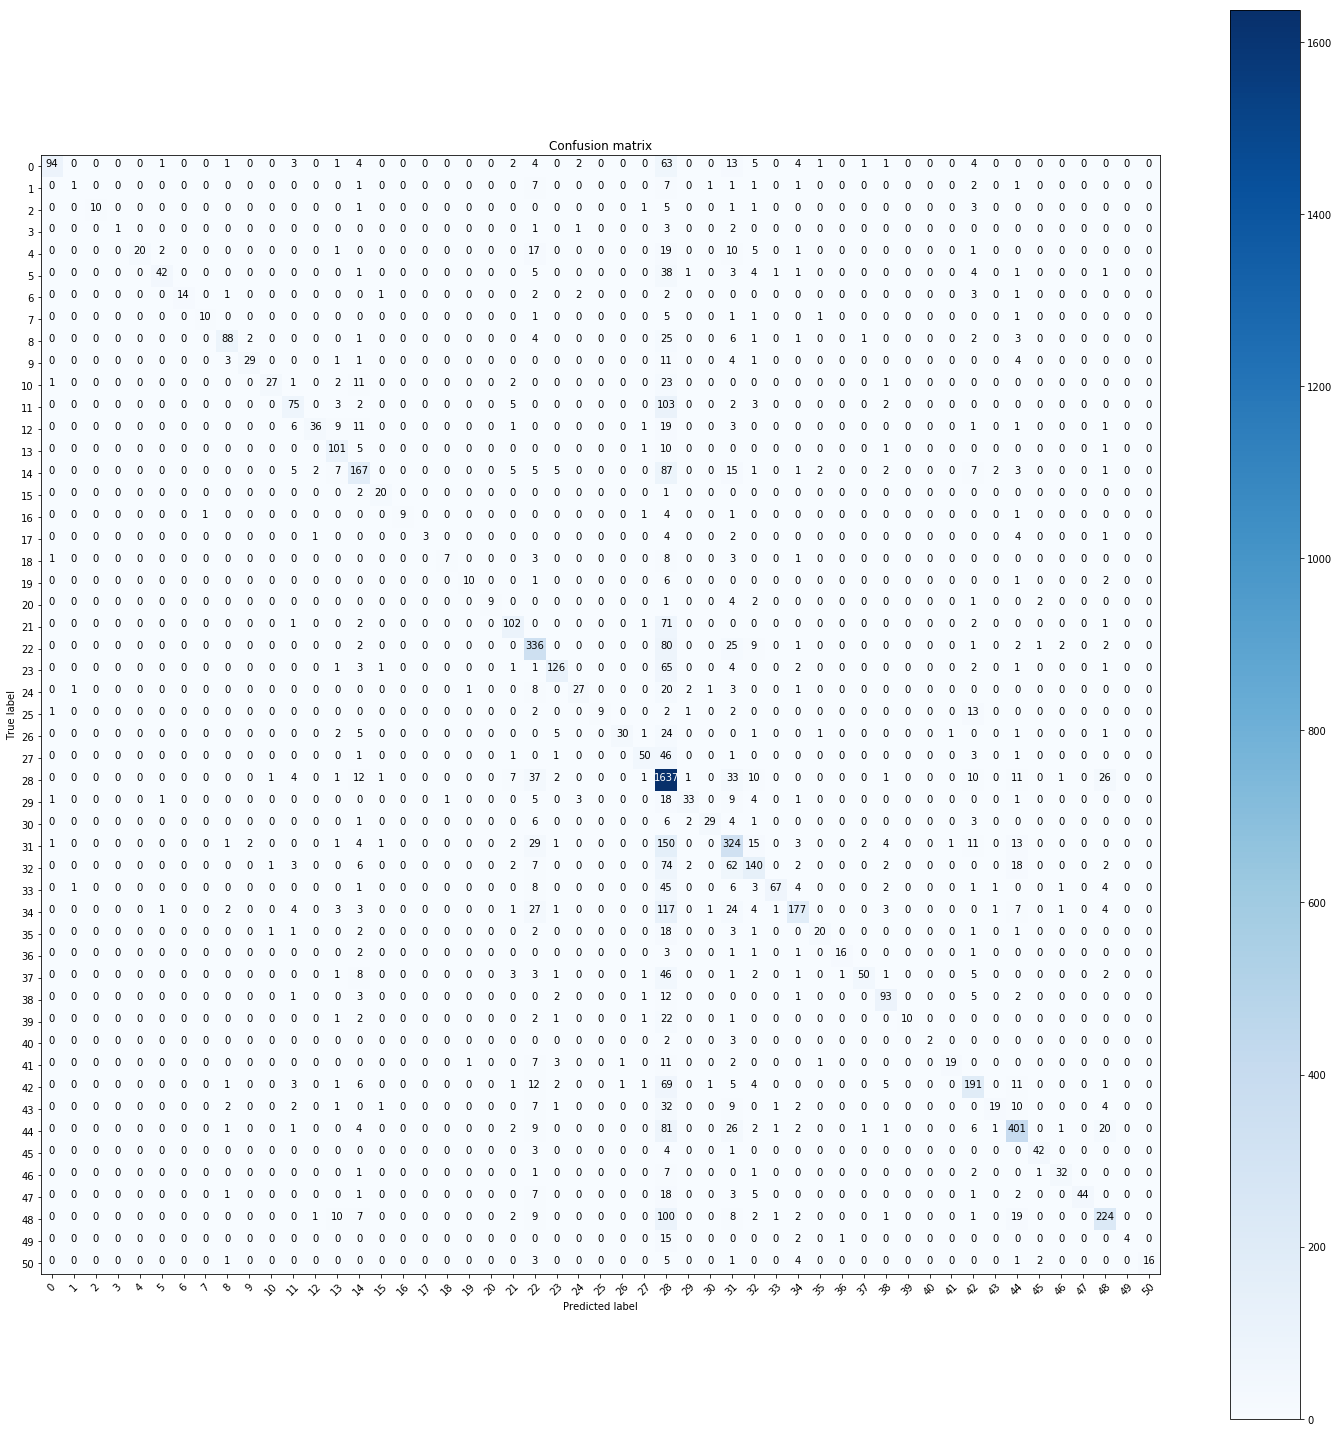

In [18]:
%matplotlib inline

import sklearn
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()
